In [33]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import math
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [34]:
def calculate_accuracy(labels, predictions):
    
    # Calculate the number of correct predictions by comparing 'labels' and 'predictions'
    correct_predictions = np.sum(labels == predictions)
    
    # Calculate the total number of predictions
    total_predictions = len(labels)
    
    # Calculate the accuracy as a percentage
    accuracy_percentage = (correct_predictions / total_predictions) * 100.0
    
    print(f"Accuracy: {accuracy_percentage:.2f}%")

In [35]:
def get_predictions(feature_data):

    prediction = model.predict(feature_data)
    
    predictions = np.argmax(prediction, axis=1)

    return predictions
    


In [36]:
def load_data(data_dir, IMG_WIDTH, IMG_HEIGHT, NUM_CATEGORIES):
    images = []
    labels = []
    
    #loop through folders
    for category in range(NUM_CATEGORIES):
        category_dir = os.path.join(data_dir, str(category))
        
        #loop through images in the class folder
        for filename in os.listdir(category_dir):
            if filename.endswith(".ppm"):
                img_path = os.path.join(category_dir, filename)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
                images.append(img)
                labels.append(category)
                
    return  (np.array(images), np.array(labels))

In [37]:
data_dir = "gtsrb"
IMG_HEIGHT = 30
IMG_WIDTH = 30
NUM_CATEGORIES = 43 #will need to change

images, labels = load_data(data_dir, IMG_WIDTH, IMG_HEIGHT, NUM_CATEGORIES)


In [38]:
print(images.shape)

(26640, 30, 30, 3)


In [39]:
reshaped_images = images.reshape(images.shape[0], -1)

In [40]:
print(reshaped_images.shape)

(26640, 2700)


In [41]:
#create scaler object
scaler = StandardScaler()

X = scaler.fit_transform(reshaped_images)

print(f"X shape: {X.shape}")
print(f"labels shape: {labels.shape}")

print(X[0])

X shape: (26640, 2700)
labels shape: (26640,)
[-0.09012238 -0.12703477 -0.1921687  ...  0.34549546  0.44860326
  0.30360699]


In [42]:
# split  data into training, CV, test sets
# use the train_test_split modules
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.4, random_state=35)

#split test set 50:50 for the CV and test sets
X_test, X_cv, y_test, y_cv = train_test_split(X_test, y_test, test_size=0.5)

#Print the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"X_cv shape: {X_cv.shape}")

print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")
print(f"y_cv shape: {y_cv.shape}")


X_train shape: (15984, 2700)
X_test shape: (5328, 2700)
X_cv shape: (5328, 2700)
y_train shape: (15984,)
y_test shape: (5328,)
y_cv shape: (5328,)


In [43]:
num_classes = len(np.unique(labels))
print("Num classes: ", num_classes)

Num classes:  43


In [44]:
#create model
model = Sequential([
    tf.keras.Input(shape=(2700,)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.0)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.0)),
    Dense(64, activation='relu', kernel_regularizer=l2(0.0)),
    Dense(10, activation='relu', kernel_regularizer=l2(0.0)),
    Dense(num_classes, activation='linear')
])

In [45]:
#print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                86432     
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 64)                1088      
                                                                 
 dense_8 (Dense)             (None, 10)                650       
                                                                 
 dense_9 (Dense)             (None, 43)                473       
                                                                 
Total params: 89171 (348.32 KB)
Trainable params: 89171 (348.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
#compile model
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=['accuracy']    
)

#fit the model
history = model.fit(
    X, labels,
    validation_data=(X_cv, y_cv),
    epochs=100
)

Epoch 1/100
833/833 [==============================] - 2s 2ms/step - loss: 2.3652 - accuracy: 0.3486 - val_loss: 1.3724 - val_accuracy: 0.5709
Epoch 2/100
833/833 [==============================] - 1s 2ms/step - loss: 1.1448 - accuracy: 0.6425 - val_loss: 1.1267 - val_accuracy: 0.6762
Epoch 3/100
833/833 [==============================] - 1s 2ms/step - loss: 0.7807 - accuracy: 0.7582 - val_loss: 0.6475 - val_accuracy: 0.7973
Epoch 4/100
833/833 [==============================] - 1s 2ms/step - loss: 0.6020 - accuracy: 0.8166 - val_loss: 0.5051 - val_accuracy: 0.8392
Epoch 5/100
833/833 [==============================] - 1s 2ms/step - loss: 0.5058 - accuracy: 0.8435 - val_loss: 0.4558 - val_accuracy: 0.8560
Epoch 6/100
833/833 [==============================] - 1s 2ms/step - loss: 0.4549 - accuracy: 0.8604 - val_loss: 0.4468 - val_accuracy: 0.8609
Epoch 7/100
833/833 [==============================] - 1s 2ms/step - loss: 0.4122 - accuracy: 0.8720 - val_loss: 0.3634 - val_accuracy: 0.8804

In [47]:
#list history data
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


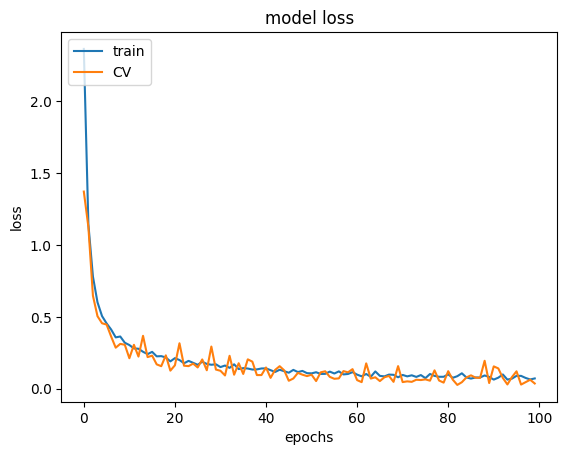

In [48]:
#summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'CV'], loc='upper left')
plt.show()

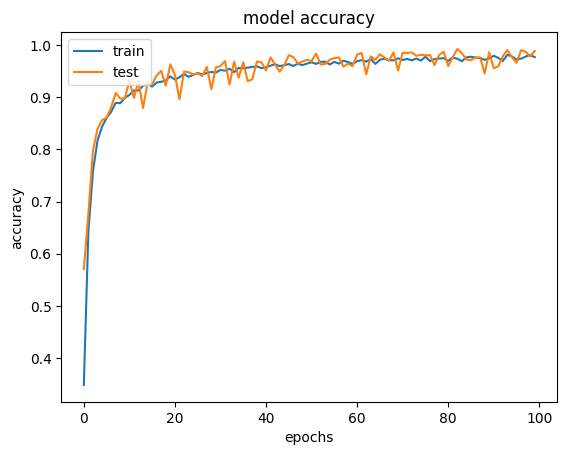

In [49]:
#summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [50]:
prediction_train = get_predictions(X_train) 
print(f"Prediction Values: {prediction_train}")

500/500 [==============================] - 0s 789us/step
Prediction Values: [ 2  7 21 ...  9 18  5]


In [51]:
calculate_accuracy(y_train, prediction_train)

Accuracy: 98.79%


In [52]:
#determine the accuracy for cv set
prediction_cv = get_predictions(X_cv)

167/167 [==============================] - 0s 801us/step


In [53]:
calculate_accuracy(y_cv, prediction_cv)

Accuracy: 98.84%


In [54]:
#evaluate model on test set
print("Evaluate on test Data")
results = model.evaluate(X_test, y_test)
print(f"test loss, test acc: {results}")

Evaluate on test Data
167/167 [==============================] - 0s 892us/step - loss: 0.0465 - accuracy: 0.9865
test loss, test acc: [0.046549491584300995, 0.9864864945411682]


In [55]:
#determine the accuracy for test set
prediction_test = get_predictions(X_test)

167/167 [==============================] - 0s 825us/step


In [56]:
calculate_accuracy(y_test, prediction_test)

Accuracy: 98.65%
